In [1]:
!wget https://isic-challenge-data.s3.amazonaws.com/2020/ISIC_2020_Training_JPEG.zip

--2025-11-19 21:51:02--  https://isic-challenge-data.s3.amazonaws.com/2020/ISIC_2020_Training_JPEG.zip
Resolving isic-challenge-data.s3.amazonaws.com (isic-challenge-data.s3.amazonaws.com)... 52.216.40.161, 16.182.34.33, 52.217.47.156, ...
Connecting to isic-challenge-data.s3.amazonaws.com (isic-challenge-data.s3.amazonaws.com)|52.216.40.161|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24707698022 (23G) [application/zip]
Saving to: ‘ISIC_2020_Training_JPEG.zip’

ISIC_2020_Training_ 100%[===================>]  23.01G  31.0MB/s    in 10m 11s 

2025-11-19 22:01:14 (38.6 MB/s) - ‘ISIC_2020_Training_JPEG.zip’ saved [24707698022/24707698022]



In [2]:
!wget https://isic-challenge-data.s3.amazonaws.com/2020/ISIC_2020_Training_GroundTruth.csv

--2025-11-19 22:01:14--  https://isic-challenge-data.s3.amazonaws.com/2020/ISIC_2020_Training_GroundTruth.csv
Resolving isic-challenge-data.s3.amazonaws.com (isic-challenge-data.s3.amazonaws.com)... 3.5.22.1, 3.5.16.61, 3.5.16.35, ...
Connecting to isic-challenge-data.s3.amazonaws.com (isic-challenge-data.s3.amazonaws.com)|3.5.22.1|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2056020 (2.0M) [text/csv]
Saving to: ‘ISIC_2020_Training_GroundTruth.csv’

ISIC_2020_Training_ 100%[===================>]   1.96M  5.30MB/s    in 0.4s    

2025-11-19 22:01:14 (5.30 MB/s) - ‘ISIC_2020_Training_GroundTruth.csv’ saved [2056020/2056020]



In [3]:
!wget https://isic-challenge-data.s3.amazonaws.com/2020/ISIC_2020_Training_Duplicates.csv

--2025-11-19 22:01:15--  https://isic-challenge-data.s3.amazonaws.com/2020/ISIC_2020_Training_Duplicates.csv
Resolving isic-challenge-data.s3.amazonaws.com (isic-challenge-data.s3.amazonaws.com)... 54.231.128.25, 3.5.6.217, 16.15.201.180, ...
Connecting to isic-challenge-data.s3.amazonaws.com (isic-challenge-data.s3.amazonaws.com)|54.231.128.25|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11500 (11K) [text/csv]
Saving to: ‘ISIC_2020_Training_Duplicates.csv’

ISIC_2020_Training_ 100%[===================>]  11.23K  --.-KB/s    in 0s      

2025-11-19 22:01:15 (221 MB/s) - ‘ISIC_2020_Training_Duplicates.csv’ saved [11500/11500]



In [4]:
import zipfile

zip_path = "/content/ISIC_2020_Training_JPEG.zip"
extract_to = "/content/ISIC_2020_JPEG"

with zipfile.ZipFile(zip_path, 'r') as z:
    z.extractall(extract_to)

print("Done!")


Done!


In [6]:
import pandas as pd

gt_path = "/content/ISIC_2020_Training_GroundTruth.csv"
dup_path = "/content/ISIC_2020_Training_Duplicates.csv"

gt = pd.read_csv(gt_path)
dups = pd.read_csv(dup_path)

print("GROUND TRUTH COLUMNS:\n", gt.columns)
print("DUPLICATE FILE COLUMNS:\n", dups.columns)
print("Shape GT:", gt.shape, "Shape dups:", dups.shape)


GROUND TRUTH COLUMNS:
 Index(['image_name', 'patient_id', 'sex', 'age_approx',
       'anatom_site_general_challenge', 'diagnosis', 'benign_malignant',
       'target'],
      dtype='object')
DUPLICATE FILE COLUMNS:
 Index(['image_name_1', 'image_name_2'], dtype='object')
Shape GT: (33126, 8) Shape dups: (425, 2)


In [7]:
dup_all = pd.unique(
    pd.concat([dups["image_name_1"], dups["image_name_2"]], axis=0)
)


In [8]:
df = gt[~gt["image_name"].isin(dup_all)].reset_index(drop=True)


In [9]:
from sklearn.model_selection import train_test_split

patients = df["patient_id"].unique()
patient_targets = df.groupby("patient_id")["target"].max()

train_patients, val_patients = train_test_split(
    patients,
    test_size=0.2,
    random_state=42,
    stratify=patient_targets
)

train_df = df[df["patient_id"].isin(train_patients)].reset_index(drop=True)
val_df   = df[df["patient_id"].isin(val_patients)].reset_index(drop=True)


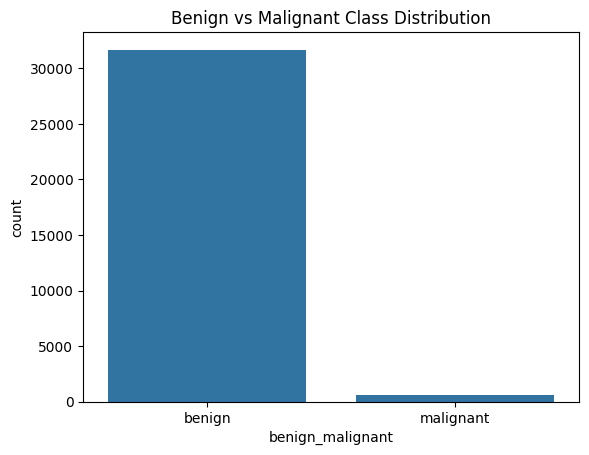

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=df, x="benign_malignant",
              order=["benign", "malignant"])
plt.title("Benign vs Malignant Class Distribution")
plt.show()


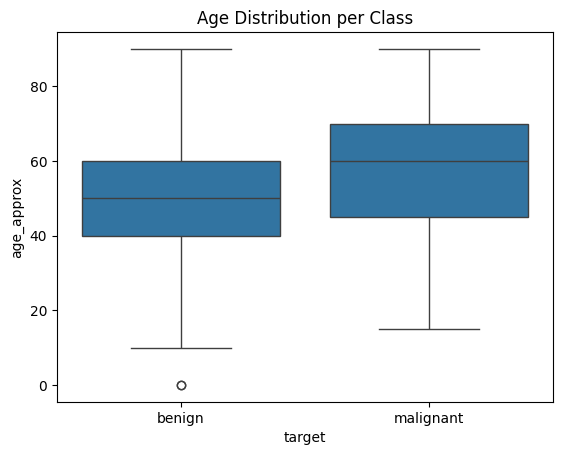

In [11]:
sns.boxplot(data=df, x="target", y="age_approx")
plt.xticks([0,1], ["benign", "malignant"])
plt.title("Age Distribution per Class")
plt.show()


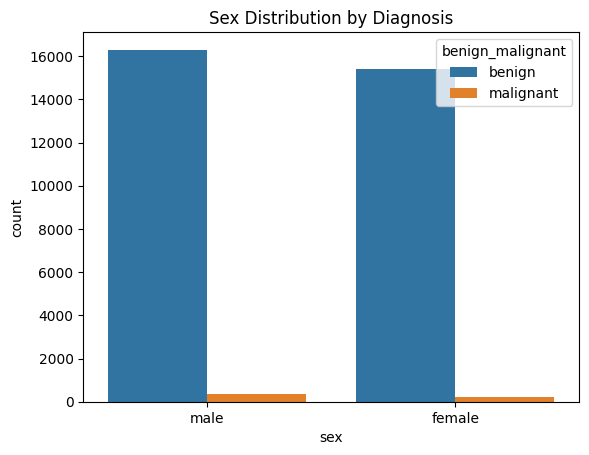

In [12]:
sns.countplot(data=df, x="sex", hue="benign_malignant")
plt.title("Sex Distribution by Diagnosis")
plt.show()


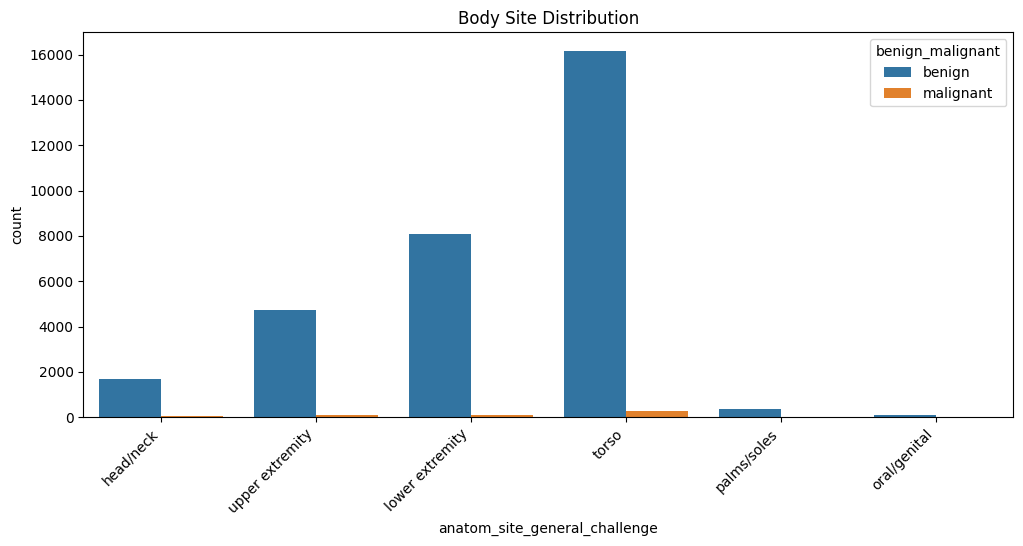

In [13]:
plt.figure(figsize=(12,5))
sns.countplot(data=df, x="anatom_site_general_challenge",
              hue="benign_malignant")
plt.xticks(rotation=45, ha='right')
plt.title("Body Site Distribution")
plt.show()


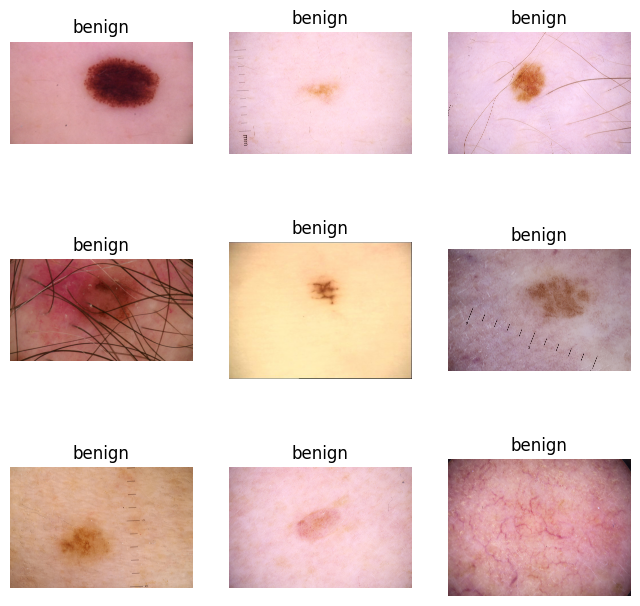

In [14]:
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt

image_dir = "/content/ISIC_2020_JPEG/train"  # <-- UPDATED

sample = df.sample(9)

plt.figure(figsize=(8,8))
for i, (_, row) in enumerate(sample.iterrows(), 1):
    name = row["image_name"]
    img_path = next(Path(image_dir).glob(f"{name}.*"))
    img = Image.open(img_path)
    plt.subplot(3,3,i)
    plt.imshow(img)
    plt.title(row["benign_malignant"])
    plt.axis("off")
plt.show()


In [15]:
image_dir = "/content/ISIC_2020_JPEG/train"


In [16]:
from torchvision import models
import torch.nn as nn

def get_resnet50(pretrained=True):
    model = models.resnet50(
        weights=models.ResNet50_Weights.IMAGENET1K_V2 if pretrained else None
    )
    model.fc = nn.Linear(model.fc.in_features, 1)  # binary output
    return model


In [17]:
from torch.utils.data import Dataset
from PIL import Image
import torch
from pathlib import Path

class ISICDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df.reset_index(drop=True)
        self.img_dir = Path(img_dir)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = next(self.img_dir.glob(f"{row['image_name']}.*"))
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        label = torch.tensor(int(row["target"]), dtype=torch.float32)
        return img, label


In [18]:
import torchvision.transforms as T

img_size = 256

train_tfms = T.Compose([
    T.Resize((img_size, img_size)),
    T.RandomHorizontalFlip(),
    T.RandomVerticalFlip(),
    T.RandomRotation(20),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    T.RandomResizedCrop((img_size, img_size), scale=(0.8, 1.0)),
    T.ToTensor(),
    T.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

val_tfms = T.Compose([
    T.Resize((img_size, img_size)),
    T.ToTensor(),
    T.Normalize(mean=[0.5]*3, std=[0.5]*3)
])


In [21]:
from sklearn.model_selection import train_test_split

patients = df["patient_id"].unique()
patient_targets = df.groupby("patient_id")["target"].max()

train_patients, val_patients = train_test_split(
    patients,
    test_size=0.2,
    random_state=42,
    stratify=patient_targets
)

train_df = df[df["patient_id"].isin(train_patients)].reset_index(drop=True)
val_df   = df[df["patient_id"].isin(val_patients)].reset_index(drop=True)

print("Train:", train_df.shape, "Val:", val_df.shape)


Train: (25932, 8) Val: (6344, 8)


In [22]:
train_df.to_csv("/content/train_split.csv", index=False)
val_df.to_csv("/content/val_split.csv", index=False)


In [23]:
from torch.utils.data import DataLoader

train_df = pd.read_csv("/content/train_split.csv")
val_df   = pd.read_csv("/content/val_split.csv")

train_data = ISICDataset(train_df, image_dir, transform=train_tfms)
val_data   = ISICDataset(val_df, image_dir, transform=val_tfms)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_data, batch_size=32, shuffle=False, num_workers=2)


In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import roc_auc_score
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)

model = get_resnet50(pretrained=True).to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

best_auc = 0.0
patience = 3  # early stopping if no improvement for 3 epochs
wait = 0

def evaluate(model, loader):
    model.eval()
    logits_list, targets_list = [], []
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            logits = model(x).squeeze(1)
            logits_list.extend(logits.cpu().numpy())
            targets_list.extend(y.cpu().numpy())
    auc = roc_auc_score(targets_list, logits_list)
    return auc

for epoch in range(10):  # your choice: 10 epochs
    model.train()
    total_loss = 0

    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/10", leave=False)
    for x, y in loop:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(x).squeeze(1)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * x.size(0)

    train_loss = total_loss / len(train_loader.dataset)
    val_auc = evaluate(model, val_loader)

    print(f"Epoch {epoch+1}: loss={train_loss:.4f}, val AUC={val_auc:.4f}")

    # Early stopping & saving best model
    if val_auc > best_auc:
        best_auc = val_auc
        torch.save(model.state_dict(), "/content/isic_best_model.pt")
        wait = 0
        print("✔️  New best model saved!")
    else:
        wait += 1
        if wait >= patience:
            print("⛔ Early stopping triggered.")
            break

print("📌 Best Validation AUC:", best_auc)


Using: cuda
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 193MB/s]


KeyboardInterrupt: 

In [25]:
from torchvision import models
import torch.nn as nn

def get_tiny_mobilenet(pretrained=True):
    model = models.mobilenet_v3_small(
        weights=models.MobileNet_V3_Small_Weights.IMAGENET1K_V1 if pretrained else None
    )
    model.classifier[3] = nn.Linear(model.classifier[3].in_features, 1)
    return model


In [31]:
import torch, os
import torch.nn as nn
from torchvision import transforms as T
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from pathlib import Path
import pandas as pd
from sklearn.metrics import roc_auc_score
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ORIGINAL folder
orig_dir = Path("/content/ISIC_2020_JPEG/train")

# RESIZED folder (we will create this)
small_dir = Path("/content/ISIC_2020_small")
small_dir.mkdir(exist_ok=True)


Using device: cuda


In [33]:
print("Resizing images to 128×128 only once...")

for img_path in orig_dir.glob("*.*"):
    img = Image.open(img_path).convert("RGB").resize((128,128))
    img.save(small_dir / img_path.name)

print("Done resizing!")


Resizing images to 128×128 only once...


KeyboardInterrupt: 

In [34]:
class ISICDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df.reset_index(drop=True)
        self.img_dir = Path(img_dir)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = self.img_dir / f"{row['image_name']}.jpg"
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        label = torch.tensor(int(row["target"]), dtype=torch.float32)
        return img, label


In [35]:
tfm = T.Compose([
    T.ToTensor(),
    T.Normalize([0.5]*3, [0.5]*3)
])


In [36]:
train_df = pd.read_csv("/content/train_split.csv")
val_df   = pd.read_csv("/content/val_split.csv")

train_data = ISICDataset(train_df, small_dir, transform=tfm)
val_data   = ISICDataset(val_df, small_dir, transform=tfm)

train_loader = DataLoader(
    train_data, batch_size=128, shuffle=True,
    num_workers=8, pin_memory=True, prefetch_factor=2
)

val_loader = DataLoader(
    val_data, batch_size=128, shuffle=False,
    num_workers=8, pin_memory=True, prefetch_factor=2
)


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [37]:
from torchvision import models

def get_tiny_mobilenet(pretrained=True):
    model = models.mobilenet_v3_small(
        weights=models.MobileNet_V3_Small_Weights.IMAGENET1K_V1 if pretrained else None
    )
    model.classifier[3] = nn.Linear(model.classifier[3].in_features, 1)
    return model

model = get_tiny_mobilenet().to(device)

# Freeze backbone
for p in model.features.parameters():
    p.requires_grad = False


In [38]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
scaler = torch.amp.GradScaler("cuda")

best_auc = 0

def evaluate(model, loader):
    model.eval()
    preds, targets = [], []
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            logits = model(x).squeeze(1)
            preds.extend(logits.cpu().numpy())
            targets.extend(y.cpu().numpy())
    return roc_auc_score(targets, preds)

for epoch in range(3):
    model.train()
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/3", leave=False)
    for x, y in loop:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        with torch.amp.autocast("cuda", dtype=torch.float16):
            loss = criterion(model(x).squeeze(1), y)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

    auc = evaluate(model, val_loader)
    print(f"Epoch {epoch+1}: AUC={auc:.4f}")

    if auc > best_auc:
        best_auc = auc
        torch.save(model.state_dict(), "/content/isic_fast_model.pt")
        print("✔️ saved!")


FileNotFoundError: Caught FileNotFoundError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/_utils/worker.py", line 349, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
           ^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/_utils/fetch.py", line 52, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
            ~~~~~~~~~~~~^^^^^
  File "/tmp/ipython-input-713774125.py", line 13, in __getitem__
    img = Image.open(img_path).convert("RGB")
          ^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/PIL/Image.py", line 3513, in open
    fp = builtins.open(filename, "rb")
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
FileNotFoundError: [Errno 2] No such file or directory: '/content/ISIC_2020_small/ISIC_4152689.jpg'


In [39]:
from pathlib import Path

small_dir = Path("/content/ISIC_2020_small")
available_images = {p.stem for p in small_dir.iterdir()}
len(available_images)


1695

In [40]:
train_df = train_df[train_df['image_name'].isin(available_images)].reset_index(drop=True)
val_df   = val_df[val_df['image_name'].isin(available_images)].reset_index(drop=True)

print("Train:", train_df.shape, "Val:", val_df.shape)


Train: (1319, 8) Val: (333, 8)


In [41]:
train_data = ISICDataset(train_df, small_dir, transform=tfm)
val_data   = ISICDataset(val_df, small_dir, transform=tfm)

train_loader = DataLoader(
    train_data, batch_size=128, shuffle=True,
    num_workers=8, pin_memory=True, prefetch_factor=2
)
val_loader = DataLoader(
    val_data, batch_size=128, shuffle=False,
    num_workers=8, pin_memory=True, prefetch_factor=2
)


In [42]:
from torchvision import models

def get_tiny_mobilenet(pretrained=True):
    model = models.mobilenet_v3_small(
        weights=models.MobileNet_V3_Small_Weights.IMAGENET1K_V1 if pretrained else None
    )
    model.classifier[3] = nn.Linear(model.classifier[3].in_features, 1)
    return model

model = get_tiny_mobilenet().to(device)

# Freeze backbone
for p in model.features.parameters():
    p.requires_grad = False


In [45]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
scaler = torch.amp.GradScaler("cuda")

best_auc = 0

def evaluate(model, loader):
    model.eval()
    preds, targets = [], []
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            logits = model(x).squeeze(1)
            preds.extend(logits.cpu().numpy())
            targets.extend(y.cpu().numpy())
    return roc_auc_score(targets, preds)

for epoch in range(15):
    model.train()
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/3", leave=False)
    for x, y in loop:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        with torch.amp.autocast("cuda", dtype=torch.float16):
            loss = criterion(model(x).squeeze(1), y)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

    auc = evaluate(model, val_loader)
    print(f"Epoch {epoch+1}: AUC={auc:.4f}")

    if auc > best_auc:
        best_auc = auc
        torch.save(model.state_dict(), "/content/isic_fast_model.pt")
        print("✔️ saved!")


Epoch 1/3:   0%|          | 0/11 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 1: AUC=0.7265
✔️ saved!


Epoch 2/3:   0%|          | 0/11 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 2: AUC=0.7200


Epoch 3/3:   0%|          | 0/11 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 3: AUC=0.7281
✔️ saved!


Epoch 4/3:   0%|          | 0/11 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 4: AUC=0.7258


Epoch 5/3:   0%|          | 0/11 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 5: AUC=0.7419
✔️ saved!


Epoch 6/3:   0%|          | 0/11 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 6: AUC=0.7565
✔️ saved!


Epoch 7/3:   0%|          | 0/11 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 7: AUC=0.7704
✔️ saved!


Epoch 8/3:   0%|          | 0/11 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 8: AUC=0.7735
✔️ saved!


Epoch 9/3:   0%|          | 0/11 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 9: AUC=0.7742
✔️ saved!


Epoch 10/3:   0%|          | 0/11 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 10: AUC=0.7731


Epoch 11/3:   0%|          | 0/11 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 11: AUC=0.7796
✔️ saved!


Epoch 12/3:   0%|          | 0/11 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 12: AUC=0.7877
✔️ saved!


Epoch 13/3:   0%|          | 0/11 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 13: AUC=0.8019
✔️ saved!


Epoch 14/3:   0%|          | 0/11 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 14: AUC=0.8104
✔️ saved!


Epoch 15/3:   0%|          | 0/11 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 15: AUC=0.8019


  0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 3/3 [00:01<00:00,  2.21it/s]


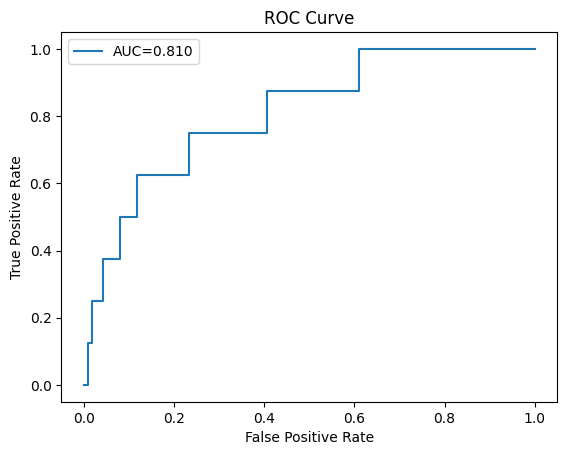

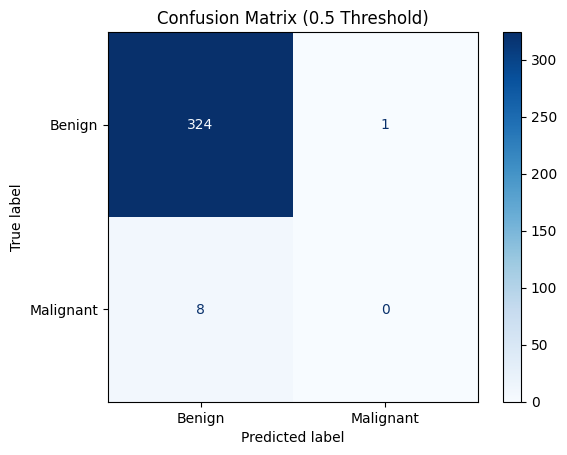

AUC: 0.8103846153846154


In [47]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay

# Load best model
model = get_tiny_mobilenet(pretrained=False).to(device)
model.load_state_dict(torch.load("/content/isic_fast_model.pt", map_location=device))
model.eval()

# Collect predictions
all_preds, all_targets = [], []
with torch.no_grad():
    for x, y in tqdm(val_loader):
        x = x.to(device)
        logits = model(x).squeeze(1)
        preds = torch.sigmoid(logits).cpu().numpy()
        all_preds.extend(preds)
        all_targets.extend(y.numpy())

all_preds = np.array(all_preds)
all_targets = np.array(all_targets)

# ROC Curve
fpr, tpr, _ = roc_curve(all_targets, all_preds)
auc = roc_auc_score(all_targets, all_preds)

plt.plot(fpr, tpr, label=f"AUC={auc:.3f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# Confusion Matrix at threshold 0.5
threshold = 0.5
cm = confusion_matrix(all_targets, (all_preds > threshold).astype(int))
disp = ConfusionMatrixDisplay(cm, display_labels=["Benign", "Malignant"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix (0.5 Threshold)")
plt.show()

print("AUC:", auc)


Image: /content/ISIC_2020_small/ISIC_9412122.jpg


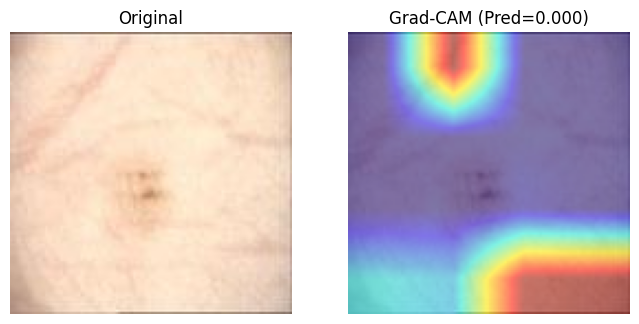

In [49]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms as T
from pathlib import Path

# ======= Load the trained model =======
model = get_tiny_mobilenet(pretrained=False).to(device)
model.load_state_dict(torch.load("/content/isic_fast_model.pt", map_location=device))
model.eval()

# ======= Pick a random validation image =======
sample = val_df.sample(1).iloc[0]
img_path = small_dir / f"{sample['image_name']}.jpg"
print("Image:", img_path)

# ======= Preprocess =======
tfm = T.Compose([
    T.ToTensor(),
    T.Normalize([0.5]*3, [0.5]*3)
])

img = Image.open(img_path).convert("RGB")
input_tensor = tfm(img).unsqueeze(0).to(device)

# ======= Grad-CAM target layer =======
target_layer = model.features[-1]  # last conv layer

# ======= Forward + Hook capture =======
gradients, activations = [], []

def hook_activation(module, inp, out):
    activations.append(out)

def hook_gradient(module, grad_in, grad_out):
    gradients.append(grad_out[0])

target_layer.register_forward_hook(hook_activation)
target_layer.register_full_backward_hook(hook_gradient)

# ======= Forward =======
logits = model(input_tensor)
score = logits.squeeze()

# ======= Backward =======
model.zero_grad()
score.backward(retain_graph=True)

# ======= Compute CAM =======
grad = gradients[-1].detach().cpu().numpy()
act  = activations[-1].detach().cpu().numpy()

weights = grad.mean(axis=(1,2))
cam = np.zeros(act.shape[2:], dtype=np.float32)

for i, w in enumerate(weights):
    cam += w * act[0, i, :, :]

cam = np.maximum(cam, 0)
cam = cv2.resize(cam, (img.size[0], img.size[1]))

# Normalize & convert to uint8 safely
cam -= cam.min()
cam /= cam.max() + 1e-8
cam_uint8 = np.uint8(cam * 255)

# ======= Apply heatmap =======
heatmap = cv2.applyColorMap(cam_uint8, cv2.COLORMAP_JET)
heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

overlay = (0.5 * np.array(img) + 0.5 * heatmap).astype(np.uint8)

# ======= Plot =======
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(img)
plt.title("Original")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(overlay)
plt.title(f"Grad-CAM (Pred={torch.sigmoid(score).item():.3f})")
plt.axis("off")

plt.show()


In [ ]:
!npm install -g localtunnel


# run API first
!python3 app.py &

# expose port
!lt --port 8000


⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦
added 22 packages in 3s
⠦
⠦3 packages are looking for funding
⠦  run `npm fund` for details
⠦Traceback (most recent call last):
  File "/content/app.py", line 16, in <module>
    model = get_tiny_mobilenet(pretrained=False).to(device)
            ^^^^^^^^^^^^^^^^^^
NameError: name 'get_tiny_mobilenet' is not defined
your url is: https://common-masks-worry.loca.lt
